In [1]:
# mount drive if needed
from google.colab import drive
drive.mount('/gdrive')
# CD to your working directory to upload images or download the sample image below

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Download a sample aerial image

The sample image is an aerial image captured over Kala Nera, Greece with a spatial resolution of 13cm

In [1]:
import os
import urllib.request

# Define directory and filename
save_dir = "/content/images"
filename = "roi_kala.tif"

# Create the directory if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Add all images here
# Define the image URL
image_url = "https://raw.githubusercontent.com/MohanadDiab/langrs/main/data/roi_kala.tif"

# Download the image
image_path = os.path.join(save_dir, filename)
urllib.request.urlretrieve(image_url, image_path)

print(f"Image downloaded to: {image_path}")


Image downloaded to: /content/images/roi_kala.tif


Display the aerial image

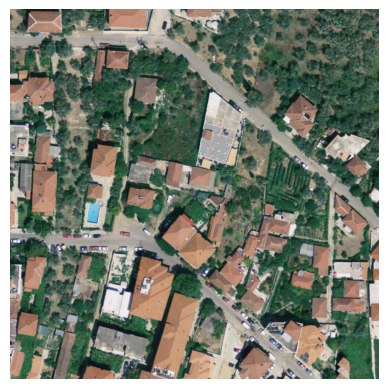

In [2]:
# display the image
import matplotlib.pyplot as plt
from PIL import Image
image = Image.open(image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

# Install LangRS

In [3]:
!pip install langrs --quiet

# Setting the parameters
In this notebook, we provide an example of how to use the langrs package using an image and a text input.


*   The image input is provided as a tif file, and the text input is the object to be segmented in the provided aerial image.

*   Grounding Dino is used first to provide bounding boxes for the object specified in the text input

* Outlier rejection is then applied to the resulting bounding boxes to filter out the non-homogenous sized bounding boxes.

* Segment Anything Model (SAM) is then used to produce the segmentation masks, utilizing the boudnding boxes resulting from the previous steps.

* Finally, visualization is provided to both our segmentation output and the segmentation output of the SamGeo output. A qualitative anlysis shows that the techniques deployed in our approach achieves better results in a setting where objects of homogenous sizes are to be segmented.





Install the package using pip

3 main inputs are required when an instance is to be initiated:

1. image: String that indicates the path to the input Tiff file.
2. prompt: A string representing the object of interest that needs to be segmented in the aerial image.
3. output_path: An output folder path, a folder with a timestamp will be created in this folder which will hold all the plots.

In [4]:
prompt = 'roof'
output_path = 'output'
seg_params = {"box_threshold": 0.25, "text_threshold": 0.25}

# SamGeo

In [5]:
from samgeo.text_sam import LangSAM
samgeo = LangSAM()

final text_encoder_type: bert-base-uncased


In [6]:
samgeo.predict(image_path, prompt, **seg_params)

In [7]:
samgeo_bb = samgeo.boxes.tolist()

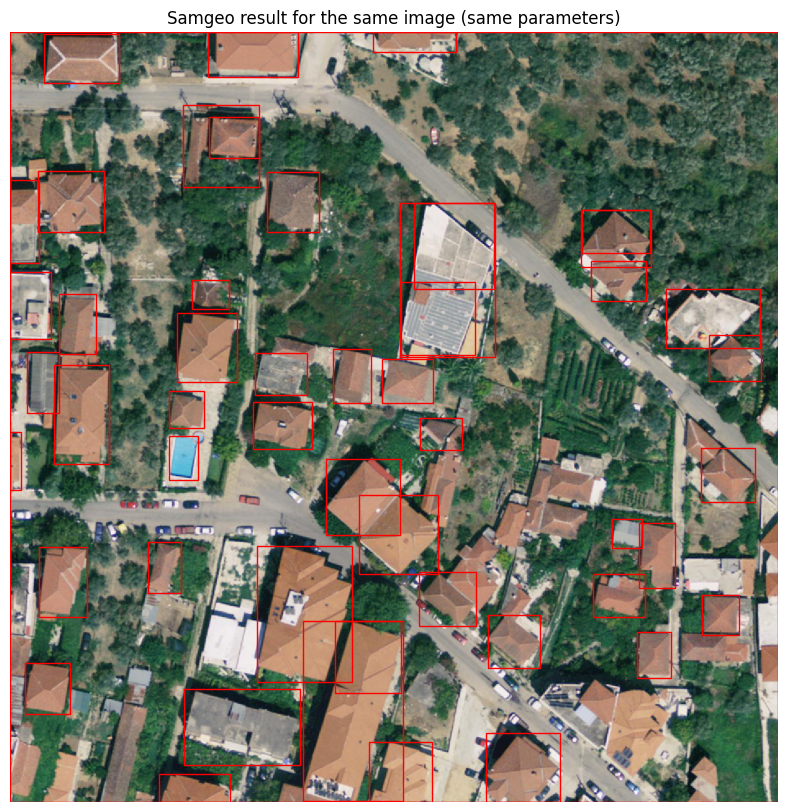

In [8]:
samgeo.show_anns(
    cmap="viridis",
    add_boxes=True,
    alpha=0,
    title="Samgeo result for the same image (same parameters)",
)

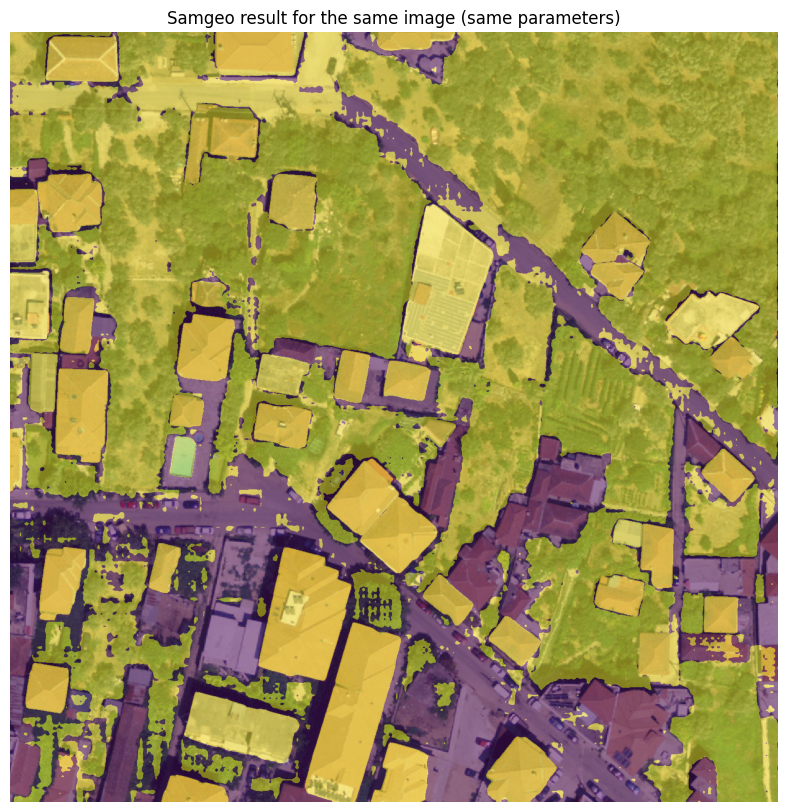

In [9]:
samgeo_masks = samgeo.masks
samgeo.show_anns(
    cmap="viridis",
    add_boxes=False,
    alpha=0.5,
    title="Samgeo result for the same image (same parameters)",
)

Trying Samgeo with different input parameters

#LangRS

Import LangRS

In [10]:
from langrs import LangRS

In [11]:
model = LangRS(image=image_path, prompt=prompt, output_path=output_path)

final text_encoder_type: bert-base-uncased


Now, we are going to generate the bounding boxes.

However, unlike SamGeo, the inference is not going to be done on the entire image, instead, it will be done on smaller 'chunks' of the input images based on the sliding window.

In [12]:
bounding_boxes = model.generate_boxes(window_size=600, overlap=300, **seg_params)

In [13]:
input_image = model.pil_image

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def plot_bounding_boxes(image, bounding_boxes, box_color='r', linewidth=1, figsize=(10, 10), title="Bounding Boxes"):
    """
    Plots bounding boxes on an input image.

    Parameters:
    - image: PIL or numpy image to be displayed.
    - bounding_boxes: List of bounding boxes in (x_min, y_min, x_max, y_max) format.
    - box_color: Color of the bounding boxes (default: 'r' for red).
    - linewidth: Thickness of the bounding box lines (default: 1).
    - figsize: Size of the figure (default: (10, 10)).
    - title: Title of the plot (default: "Bounding Boxes").
    """
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('off')
    ax.imshow(image)
    ax.set_title(title)

    for box in bounding_boxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = Rectangle((x_min, y_min), width, height, linewidth=linewidth, edgecolor=box_color, facecolor='none')
        ax.add_patch(rect)

    plt.show()

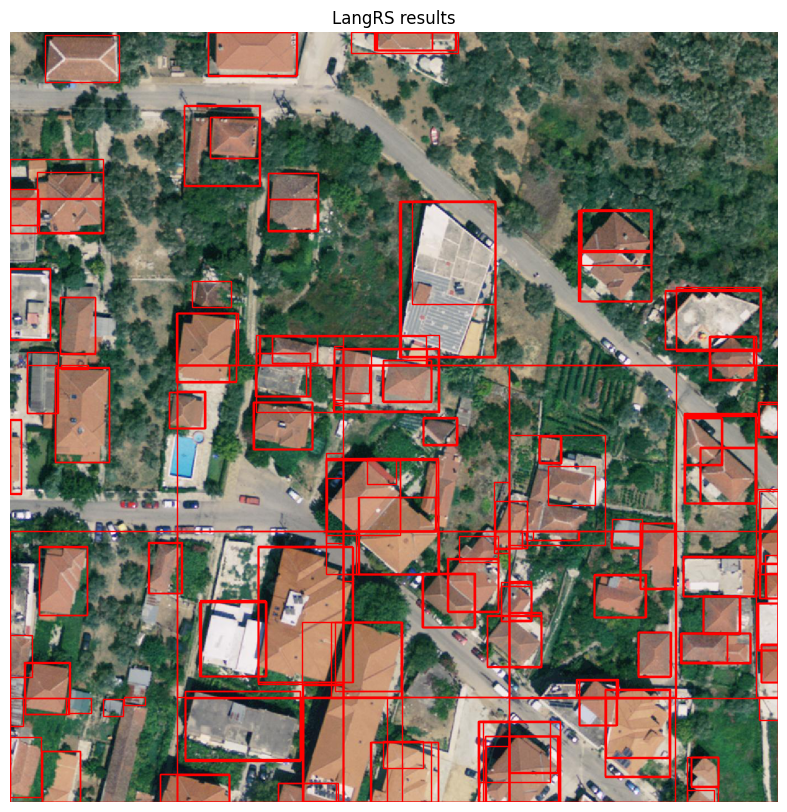

In [15]:
plot_bounding_boxes(input_image, bounding_boxes, title='LangRS results')

## Comparison of LangRS and SamGeo object detection

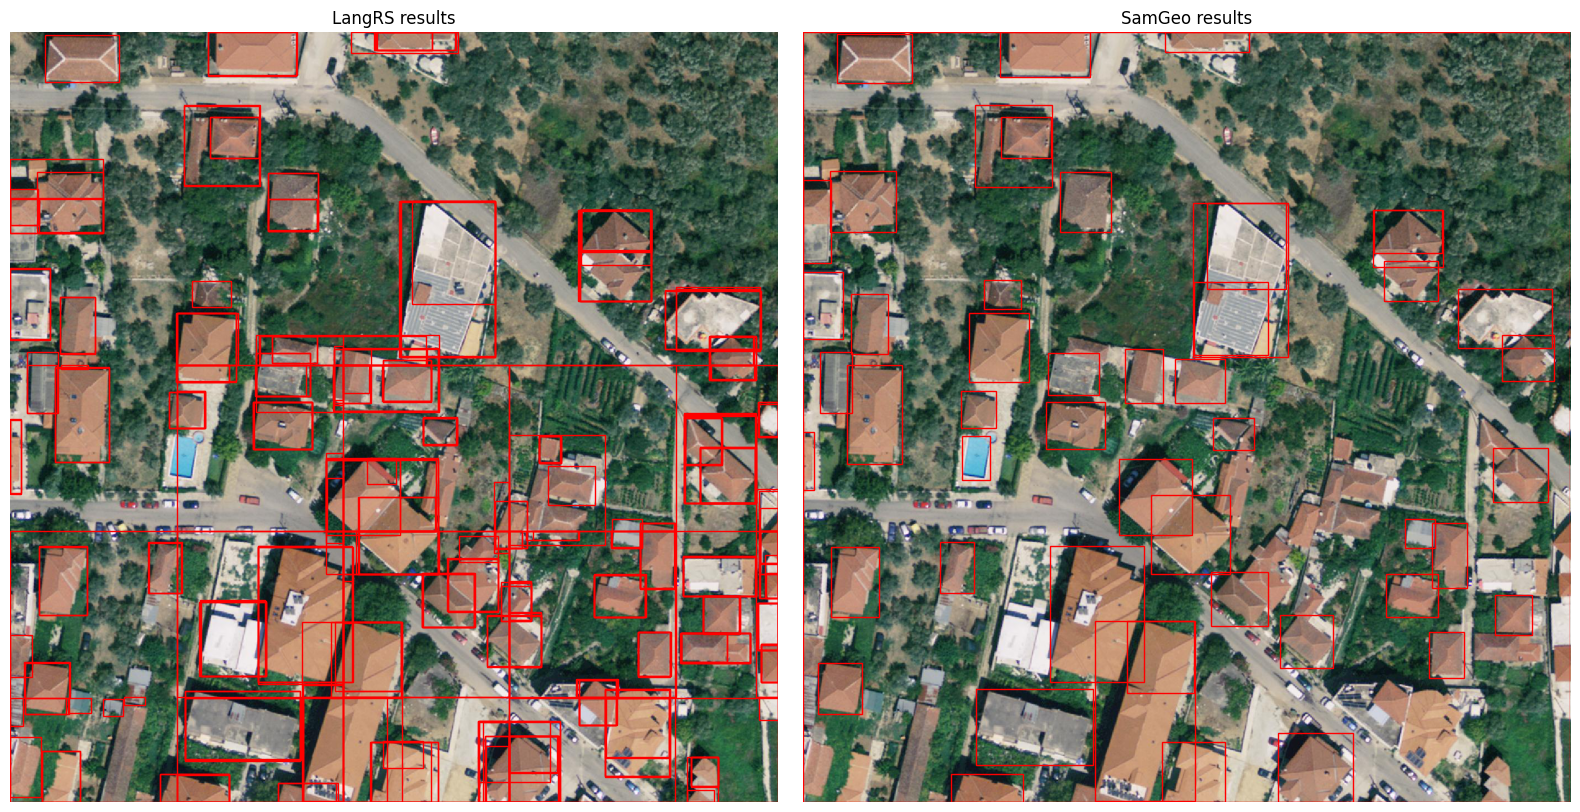

In [16]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Function to draw bounding boxes
def draw_bounding_boxes(ax, image, bounding_boxes, title):
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(title)

    for box in bounding_boxes:
        x_min, y_min, x_max, y_max = box
        width = x_max - x_min
        height = y_max - y_min
        rect = Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

# Plot the first bounding box set
draw_bounding_boxes(axes[0], input_image, bounding_boxes, "LangRS results")

# Plot the second bounding box set
draw_bounding_boxes(axes[1], input_image, samgeo_bb, "SamGeo results")

plt.tight_layout()
plt.show()


In [17]:
bboxes_filtered = model.outlier_rejection()

Output hidden; open in https://colab.research.google.com to view.

In [18]:
bboxes_filtered.keys()

dict_keys(['zscore', 'iqr', 'svm', 'svm_sgd', 'robust_covariance', 'lof', 'isolation_forest'])

All outputs are saved to the output folder

In [19]:
model.output_path

'output/20250313_195143'

We can access all the images with 'filtered' bounding boxes and visualize them.

This will allow us to qualitatively select the method with the most desirable output!

In [20]:
filtered_bb_images = []
for file in os.listdir(model.output_path):
    if 'filtered' in file:
      image_path = os.path.join(model.output_path, file)
      filtered_bb_images.append(image_path)

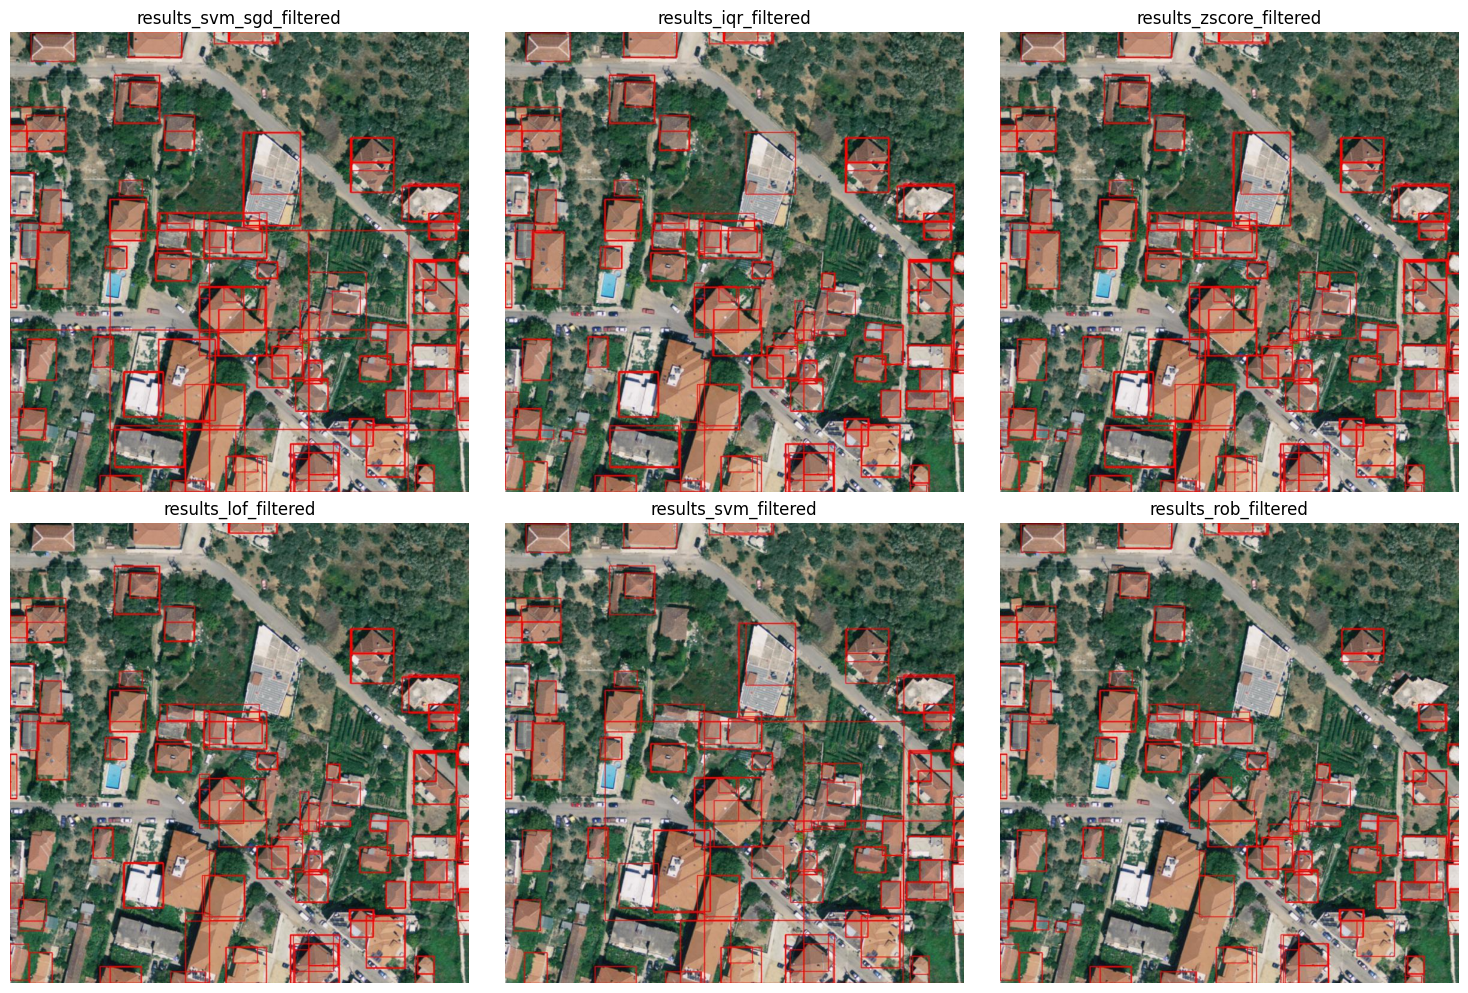

In [21]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Only use the first six images
image_paths = filtered_bb_images[:6]

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Flatten axes for easier iteration
axes = axes.flatten()

for i, image_path in enumerate(image_paths):
    image = mpimg.imread(image_path)  # Load image
    filename = os.path.splitext(os.path.basename(image_path))[0]  # Extract filename without extension

    axes[i].imshow(image)  # Show image
    axes[i].axis('off')  # Hide axes
    axes[i].set_title(filename)  # Set title

plt.tight_layout()
plt.show()
plt.close()

## Segmentation using the preferred bounding boxes set

In [22]:
masks = model.generate_masks(rejection_method="zscore")

fig, ax = plt.subplots()
ax.imshow(input_image)
ax.imshow(masks, cmap="viridis", alpha=0.4)
ax.axis('off')  # Turn off the axes

plt.title("Results of Langrs")
plt.show()
plt.close()

RuntimeError: Error in generate_masks: CUDA out of memory. Tried to allocate 1.09 GiB. GPU 0 has a total capacity of 14.74 GiB of which 294.12 MiB is free. Process 131411 has 14.45 GiB memory in use. Of the allocated memory 13.13 GiB is allocated by PyTorch, and 1.19 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

#Comparison of segmentation results

In [ ]:
samgeo_masks

In [25]:
masks

NameError: name 'masks' is not defined